In [1]:
import re
import cv2
import numpy as np
from glob import glob

import torch
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
#import torchvision

from sklearn.preprocessing import LabelEncoder
from sklearn import manifold

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip "/content/drive/MyDrive/Colab Notebooks/ComputationalArts/data.zip"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
image_names = np.array(glob("data/*.jpg"))

In [4]:
# название
image_labels = np.array(list(map(lambda image_name: re.sub("data/(.*)_\d\d.jpg", "\g<1>", image_name).lower(), image_names)), dtype = "<U62")

indexes = np.argsort(image_labels)
image_labels = image_labels[indexes]
image_names = image_names[indexes]
unique_labels = np.unique(image_labels)

In [5]:
# распределение классов
np.sum(unique_labels.reshape(-1, 1) == image_labels, axis = 1)

array([26, 36, 36, 36, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36])

In [6]:
# ориентация в пространстве 
another_image_labels = np.array(list(map(lambda image_name: re.sub(".*(\d\d)\.jpg", "\g<1>", image_name).lower(), image_names)), dtype = np.int)

In [7]:
height, width = 128 * 5, 128 * 9
down_scale = 4
images = np.zeros((len(image_labels), height // down_scale, width // down_scale, 3), dtype = np.uint8)
for i, image_name in enumerate(image_names):
    cur_image = plt.imread(image_name)[:, 9:-9]
    cur_height, cur_width = cur_image.shape[:2]
    if cur_height < height:
        cur_image = np.vstack((255 * np.ones((height - cur_height, width, 3), dtype = np.uint8), cur_image))
    else:
        cur_image = cur_image[(cur_height - height)//2:-(cur_height - height)//2, :]
    
    images[i] = cv2.resize(cur_image, (0, 0), fx = 1 / down_scale, fy = 1 / down_scale)

In [8]:
#значения пикселей изображения от -1 до +1, так как потом будем использовать tanh на последнем слое в декодере
X = (images.astype(np.float32) - 128) / 255
X = torch.Tensor(X.reshape(-1, 3, height // down_scale, width // down_scale))

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(image_labels)

In [9]:
class Encoder(nn.Module):
    def __init__(self, h, w, downsamplings=5, start_channels=8, latent_size=32):
        super().__init__()
        
        self.start_conv = nn.Conv2d(3, start_channels, 1, bias = False)
        
        # уменьшаем высоту и ширину тензора в два раза, а глубину увеличиваем в два раза
        self.downsamplings_conv = nn.Sequential(
            *[self.downsampling(start_channels * 2**i) for i in range(downsamplings)]
        )

        self.latent_size = latent_size
        self.end_conv =  nn.Conv2d(start_channels * 2 ** downsamplings, 2 * latent_size, 1, bias = False)
        
        # так как картинка не квадратная
        # если картинка имела размер 2^downsamplings, 2^downsamplings, то картнка уже была вектором
        self.end_fc = nn.Linear(2 * latent_size * (h // 2 ** downsamplings) * (w // 2 ** downsamplings), 2 * latent_size)

    def downsampling(self, cur_channels):
        return nn.Sequential(
            nn.Conv2d(cur_channels, 2 * cur_channels, 3, 2, 1, bias = False),
            nn.BatchNorm2d(2 * cur_channels, affine = False),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.start_conv(x)
        x = self.downsamplings_conv(x)
        x = self.end_conv(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.end_fc(x)
        mu = x[:, :self.latent_size]
        sigma = torch.exp(x[:, self.latent_size:])
        # чтобы иметь большую обобщаю способность
        return (mu + torch.randn_like(sigma).to(device) * sigma , mu, sigma)

In [10]:
class Decoder(nn.Module):
    def __init__(self, h, w, upsamplings=5, start_channels=128, latent_size=32):
        super().__init__()
        self.h_start = (h // 2 ** upsamplings)
        self.w_start = (w // 2 ** upsamplings)
        self.latent_size = latent_size
        
        self.start_fc = nn.Linear(latent_size,  latent_size * self.h_start * self.w_start)
        
        self.start_conv = nn.Conv2d(latent_size, start_channels, 1)
        
        self.upsamplings_conv = nn.Sequential(
            *[self.upsampling(start_channels // 2 ** i) for i in range(upsamplings)]
        )
        
        self.end_conv = nn.Conv2d(start_channels // 2 ** upsamplings, 3, 1, bias = False)

    def upsampling(self, cur_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(cur_channels, cur_channels // 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(cur_channels // 2, affine = False),
            nn.ReLU()
        )
    
    def forward(self, z):
        x = F.relu(self.start_fc(z))
        
        x = self.start_conv(x.reshape(-1, self.latent_size, self.h_start, self.w_start))
        x = self.upsamplings_conv(x)
        x = self.end_conv(x)
        
        return torch.tanh(x)

In [11]:
class VAE(nn.Module):
    def __init__(self, h, w, downsamplings=5, latent_size=32, down_channels=8, up_channels=8):
        super().__init__()
        self.encoder = Encoder(h, w, downsamplings, down_channels, latent_size)
        self.decoder = Decoder(h, w, downsamplings, up_channels * 2 ** downsamplings, latent_size)

    def forward(self, x):
        z, mu, sigma = self.encode(x)
        # хотим, что распределение стремилось к стандартному нормальному
        kld = 0.5 * (mu ** 2 + sigma ** 2 - torch.log(sigma ** 2) - 1)
        x_hat = self.decode(z)
        return x_hat, kld
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
def get_vae(X, y, latent_size=128, batch_size=8, epochs = 100):
  h, w = X.shape[-2:]
  dataset = TensorDataset(X, torch.Tensor(y))
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  vae = VAE(h, w, downsamplings=5, latent_size=latent_size, down_channels=16, up_channels=16)
  vae.to(device)

  total_batches = len(dataloader)

  vae_optim = Adam(vae.parameters(), lr=1e-4)

  for ep in range(epochs):
      reconstruction_loss_avg = 0
      kld_loss_avg = 0
      for (x, _) in dataloader:
          # наверное, по хорошему, надо семплировать из картинок
          # чтобы лучше обучить латентное пространство
          x = x.to(device)
          x_hat, kld = vae(x)
          
          kld_loss = kld.mean()
          reconstruction_loss = ((x_hat - x)**2).mean()
          
          vae_optim.zero_grad()
          loss = reconstruction_loss + 0.1 * kld_loss
          loss.backward()
          vae_optim.step()
          
          kld_loss_avg += kld_loss.item()
          reconstruction_loss_avg += reconstruction_loss.item()

      print(f"Epoch {ep+1} | Reconstruction loss: {reconstruction_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")
  return vae

In [14]:
vae = get_vae(X, y, latent_size=256, epochs=200)

Epoch 1 | Reconstruction loss: 0.09269656627489034 | KLD loss: 0.011812816938868554
Epoch 2 | Reconstruction loss: 0.052002600804772425 | KLD loss: 0.014937847225566304
Epoch 3 | Reconstruction loss: 0.03713798077316374 | KLD loss: 0.027969017304399962
Epoch 4 | Reconstruction loss: 0.03233612409882968 | KLD loss: 0.029687293224357147
Epoch 5 | Reconstruction loss: 0.029616990987892434 | KLD loss: 0.03143005299391926
Epoch 6 | Reconstruction loss: 0.027746668085455894 | KLD loss: 0.03269182692872741
Epoch 7 | Reconstruction loss: 0.026405323637268878 | KLD loss: 0.03435233114187115
Epoch 8 | Reconstruction loss: 0.025121495428104556 | KLD loss: 0.035711736748776125
Epoch 9 | Reconstruction loss: 0.024239549603593605 | KLD loss: 0.03608575001138673
Epoch 10 | Reconstruction loss: 0.02331507566475099 | KLD loss: 0.03763081632073848
Epoch 11 | Reconstruction loss: 0.022381888817675333 | KLD loss: 0.0371646635554811
Epoch 12 | Reconstruction loss: 0.021974237785945015 | KLD loss: 0.0382655

In [15]:
def plot_vae_result(x, vae):
  h, w = x.shape[-2:]
  with torch.no_grad():
    predict_x = vae(x.reshape(1, 3, h, w).to(device))[0].to('cpu')
    
  init_image = (x.detach().numpy().reshape(h, w, 3) + 1) / 2
  predict_image = (predict_x.detach().numpy().reshape(h, w, 3) + 1) / 2

  plt.imshow(np.hstack((init_image, predict_image)))

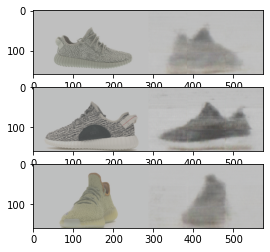

In [16]:
plt.subplot(311)
plot_vae_result(X[0], vae)
plt.subplot(312)
plot_vae_result(X[100], vae)
plt.subplot(313)
plot_vae_result(X[1000], vae)

In [17]:
def img1_convert_to_img2(x1, x2, vae):
  h, w = x1.shape[-2:]
  with torch.no_grad():
    z1 = vae.encode(x1.reshape(1, 3, h, w).to(device))[0]
    z2 = vae.encode(x2.reshape(1, 3, h, w).to(device))[0]
    
    intermediate_images = np.zeros((9, h, w, 3))
    for i in range(9):
      z = ((8 - i) * z1 +  i * z2) / 8
      intermediate_images[i] = (vae.decode(z).to('cpu').detach().numpy().reshape(h, w, 3) + 1) / 2

  plt.imshow(np.hstack(intermediate_images))

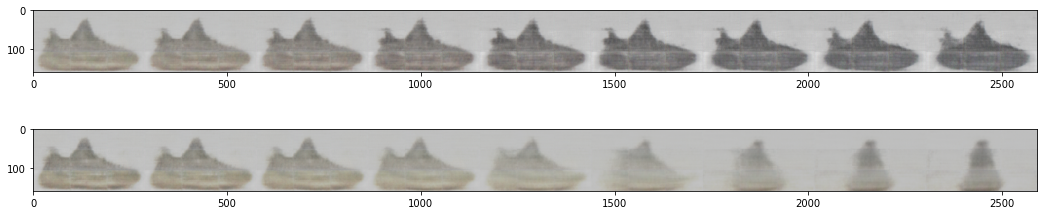

In [18]:
# достаточно резкие переходы
plt.figure(figsize=(18, 4))
plt.subplot(211)
img1_convert_to_img2(X[another_image_labels == 1][1], X[another_image_labels == 1][2], vae)
plt.subplot(212)
img1_convert_to_img2(X[another_image_labels == 1][1], X[another_image_labels == 10][1], vae)

In [19]:
with torch.no_grad():
  X_encoded = vae.encode(X.to(device))[0].to('cpu').detach().numpy()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_encoded)

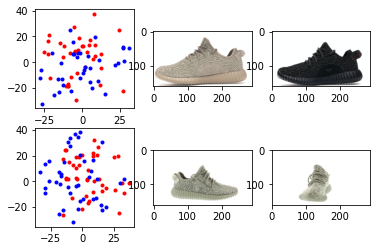

In [20]:
plt.subplot(231)
points1 = X_tsne[y == 1]
points2 = X_tsne[y == 2]
plt.plot(points1[:, 0], points1[:, 1], '.r')
plt.plot(points2[:, 0], points2[:, 1], '.b')
plt.subplot(232)
plt.imshow(images[y == 1][0])
plt.subplot(233)
plt.imshow(images[y == 2][0])

plt.subplot(234)
another_points1 = X_tsne[another_image_labels == 1]
another_points2 = X_tsne[another_image_labels == 8]
plt.plot(another_points1[:, 0], another_points1[:, 1], '.r')
plt.plot(another_points2[:, 0], another_points2[:, 1], '.b')
plt.subplot(235)
plt.imshow(images[another_image_labels == 1][0])
plt.subplot(236)
plt.imshow(images[another_image_labels == 8][0])

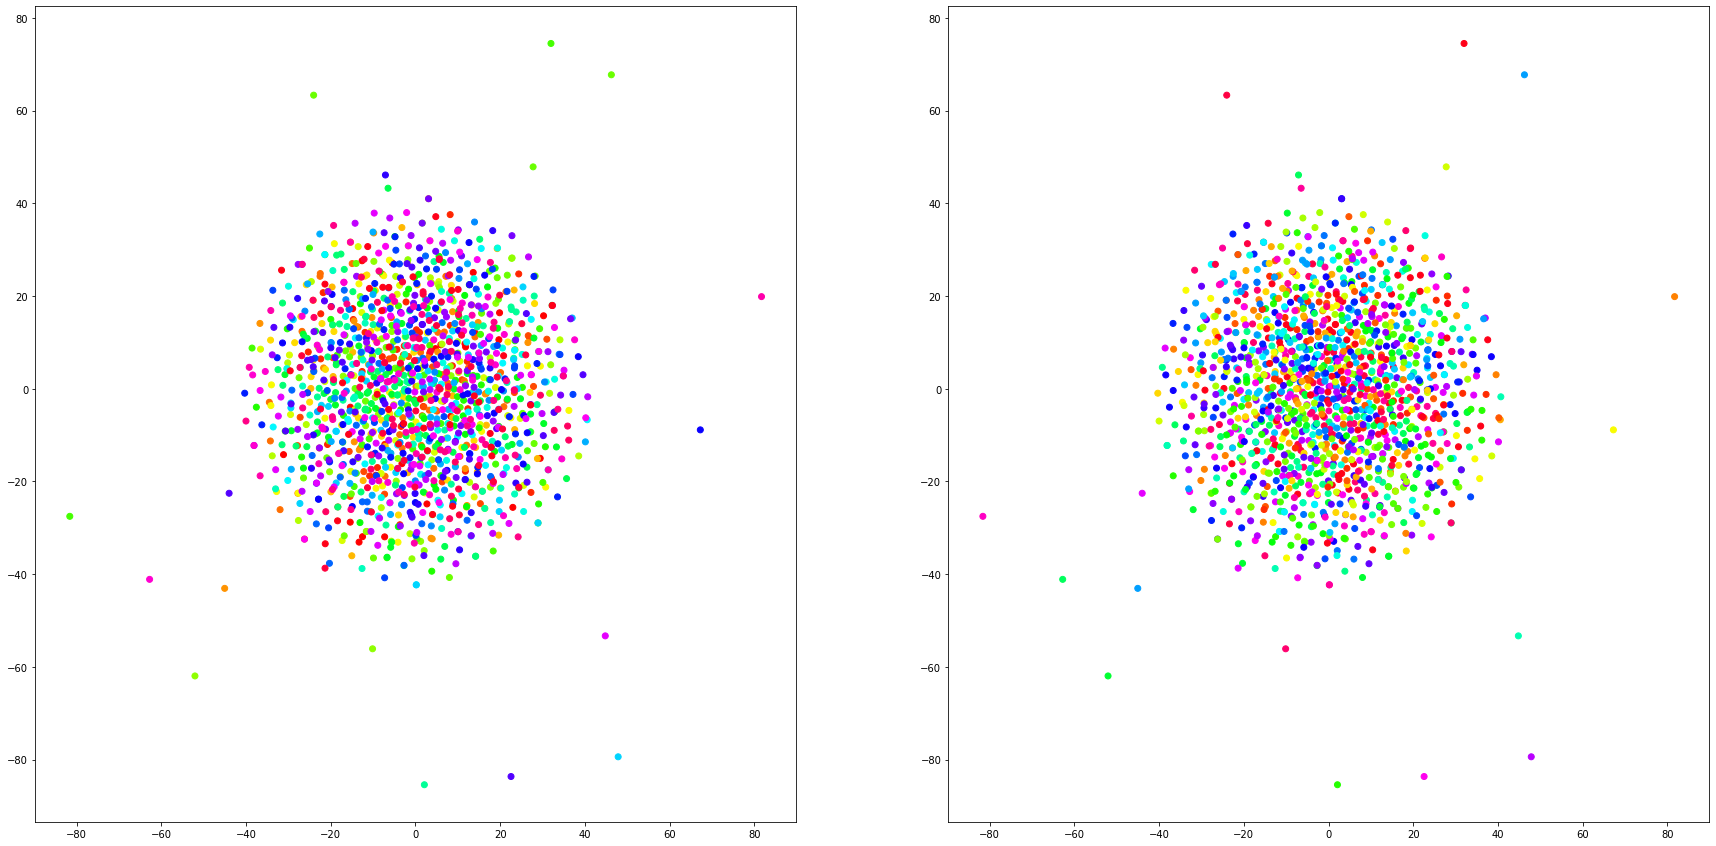

In [21]:
plt.figure(figsize = (30, 15))
plt.subplot(121)
# кластера классов
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = plt.cm.get_cmap('hsv', len(np.unique(y)))(y))
plt.subplot(122)
# кластера ориентаций
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = plt.cm.get_cmap('hsv', len(np.unique(another_image_labels)))(another_image_labels))

Может проблема в проекции пространтсва на пространтсво с маленькой размерностью? 

Вычислим метрику качества MAPk (Mean average precision at K)

In [22]:
#Average precision at K
def my_ap_k(point_class, k_nearest_class):
    true_position = np.where(k_nearest_class == point_class)[0]
    ap = 0
    if len(true_position) > 0:
        for i in range(len(true_position)):
            ap += (i+1)/(true_position[i]+1)
        ap /= len(true_position)
    return ap

In [23]:
def calc_map_k(X, y, k = 5):
  ap_array = []
  for i in range(len(X)):

    cur_point = X[i]
    cur_point_class = y[i]
    k_nearest_class = y[np.argsort(np.apply_along_axis(lambda x: np.linalg.norm(cur_point - x), 1, X))[1:k+1]]

    ap_array.append(my_ap_k(cur_point_class, k_nearest_class))
  return np.mean(ap_array)

In [24]:
k = 5
print(f"Map {k} : {calc_map_k(X_encoded, y, k)}")

Map 5 : 0.10457714799820064


In [25]:
k = 5
print(f"Map {k} : {calc_map_k(X_encoded, another_image_labels, k)}")

Map 5 : 0.10045921427500375


Можно сделать выбор, что больше затачиваемся на ориентацию, чем на марку, но все равно, пространство недостатчно хорошее.

Проблема может быть заключается в том, что слишком сильно переобучаемся на конкретном изображении?

another_image_labels не совсем корректно отвечает за ориентацию, может сделать меньше направлений?

Как понимаю, учитывание kld loss сжимает наше пространтсво в центр, попробуем сделать более упрошенную версию encoder

In [26]:
class SimpleEncoder(nn.Module):
    def __init__(self, h, w, downsamplings=5, start_channels=8, latent_size=32):
        super().__init__()
        
        self.start_conv = nn.Conv2d(3, start_channels, 1, bias = False)
        
        self.downsamplings_conv = nn.Sequential(
            *[self.downsampling(start_channels * 2**i) for i in range(downsamplings)]
        )

        self.latent_size = latent_size
        self.end_conv =  nn.Conv2d(start_channels * 2 ** downsamplings, latent_size, 1, bias = False)
        
        self.end_fc = nn.Linear(latent_size * (h // 2 ** downsamplings) * (w // 2 ** downsamplings), latent_size)

    def downsampling(self, cur_channels):
        return nn.Sequential(
            nn.Conv2d(cur_channels, 2 * cur_channels, 3, 2, 1, bias = False),
            nn.BatchNorm2d(2 * cur_channels, affine = False),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.start_conv(x)
        x = self.downsamplings_conv(x)
        x = self.end_conv(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.end_fc(x)
        return x

In [27]:
class SimpleVAE(nn.Module):
    def __init__(self, h, w, downsamplings=5, latent_size=32, down_channels=8, up_channels=8):
        super().__init__()
        self.encoder = SimpleEncoder(h, w, downsamplings, down_channels, latent_size)
        self.decoder = Decoder(h, w, downsamplings, up_channels * 2 ** downsamplings, latent_size)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

In [28]:
def get_simple_vae(X, y, latent_size=128, batch_size=8, epochs = 100):
  h, w = X.shape[-2:]

  dataset = TensorDataset(X, torch.Tensor(y))
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  simple_vae = SimpleVAE(h, w, downsamplings=5, latent_size=latent_size, down_channels=16, up_channels=16)

  simple_vae.to(device)

  total_batches = len(dataloader)

  simple_vae_optim = Adam(simple_vae.parameters(), lr=1e-4)

  for ep in range(epochs):
      reconstruction_loss_avg = 0
      for (x, _) in dataloader:
          x = x.to(device)
          x_hat = simple_vae(x)

          reconstruction_loss = ((x_hat - x)**2).mean()
          
          simple_vae_optim.zero_grad()
          reconstruction_loss.backward()
          simple_vae_optim.step()

          reconstruction_loss_avg += reconstruction_loss.item()

      print(f"Epoch {ep+1} | Reconstruction loss: {reconstruction_loss_avg / total_batches}")
  
  return simple_vae

In [29]:
simple_vae_2 = get_simple_vae(X, y, 2, epochs=200)

Epoch 1 | Reconstruction loss: 0.2001037310848954
Epoch 2 | Reconstruction loss: 0.1295594500918542
Epoch 3 | Reconstruction loss: 0.09622891467585358
Epoch 4 | Reconstruction loss: 0.07229396484551891
Epoch 5 | Reconstruction loss: 0.058696996520764086
Epoch 6 | Reconstruction loss: 0.05062044766401091
Epoch 7 | Reconstruction loss: 0.04428415425041671
Epoch 8 | Reconstruction loss: 0.04007242186375523
Epoch 9 | Reconstruction loss: 0.037123872838433714
Epoch 10 | Reconstruction loss: 0.035130754003040894
Epoch 11 | Reconstruction loss: 0.033055928435617235
Epoch 12 | Reconstruction loss: 0.03075192924789203
Epoch 13 | Reconstruction loss: 0.030666042589933
Epoch 14 | Reconstruction loss: 0.030009033368720163
Epoch 15 | Reconstruction loss: 0.028548808237637884
Epoch 16 | Reconstruction loss: 0.028074232560973012
Epoch 17 | Reconstruction loss: 0.02726234903218605
Epoch 18 | Reconstruction loss: 0.026114795442109786
Epoch 19 | Reconstruction loss: 0.02614465518103492
Epoch 20 | Recons

In [30]:
simple_vae_32 = get_simple_vae(X, y, 32, epochs=200)

Epoch 1 | Reconstruction loss: 0.1288029419718891
Epoch 2 | Reconstruction loss: 0.07789744815278438
Epoch 3 | Reconstruction loss: 0.059944655465823345
Epoch 4 | Reconstruction loss: 0.04044487021903517
Epoch 5 | Reconstruction loss: 0.029613491658481858
Epoch 6 | Reconstruction loss: 0.024080591376430246
Epoch 7 | Reconstruction loss: 0.020734939398744736
Epoch 8 | Reconstruction loss: 0.018793302798463453
Epoch 9 | Reconstruction loss: 0.016815540591074575
Epoch 10 | Reconstruction loss: 0.01610533926155298
Epoch 11 | Reconstruction loss: 0.014728108385918282
Epoch 12 | Reconstruction loss: 0.013546555678570462
Epoch 13 | Reconstruction loss: 0.01360734225681392
Epoch 14 | Reconstruction loss: 0.012788399478160245
Epoch 15 | Reconstruction loss: 0.01206992235114818
Epoch 16 | Reconstruction loss: 0.011533709548373697
Epoch 17 | Reconstruction loss: 0.01101971941409252
Epoch 18 | Reconstruction loss: 0.010393530663643633
Epoch 19 | Reconstruction loss: 0.01037795600601502
Epoch 20 | 

In [31]:
simple_vae_128 = get_simple_vae(X, y, 128, epochs=200)

Epoch 1 | Reconstruction loss: 0.07352171391649272
Epoch 2 | Reconstruction loss: 0.031686277759651986
Epoch 3 | Reconstruction loss: 0.02034468536755891
Epoch 4 | Reconstruction loss: 0.01490629280126223
Epoch 5 | Reconstruction loss: 0.01214768370533342
Epoch 6 | Reconstruction loss: 0.01086701382382182
Epoch 7 | Reconstruction loss: 0.009916275421718275
Epoch 8 | Reconstruction loss: 0.009504042297942184
Epoch 9 | Reconstruction loss: 0.0088580452476538
Epoch 10 | Reconstruction loss: 0.00829187807657065
Epoch 11 | Reconstruction loss: 0.007959748515658963
Epoch 12 | Reconstruction loss: 0.007613849503198458
Epoch 13 | Reconstruction loss: 0.007461619768692281
Epoch 14 | Reconstruction loss: 0.007284812423931334
Epoch 15 | Reconstruction loss: 0.00702064578741869
Epoch 16 | Reconstruction loss: 0.006778819461463279
Epoch 17 | Reconstruction loss: 0.006561335879728519
Epoch 18 | Reconstruction loss: 0.006318856013177704
Epoch 19 | Reconstruction loss: 0.006137360378058367
Epoch 20 | 

Увелечение latent size ведет к заметному приросту в качестве

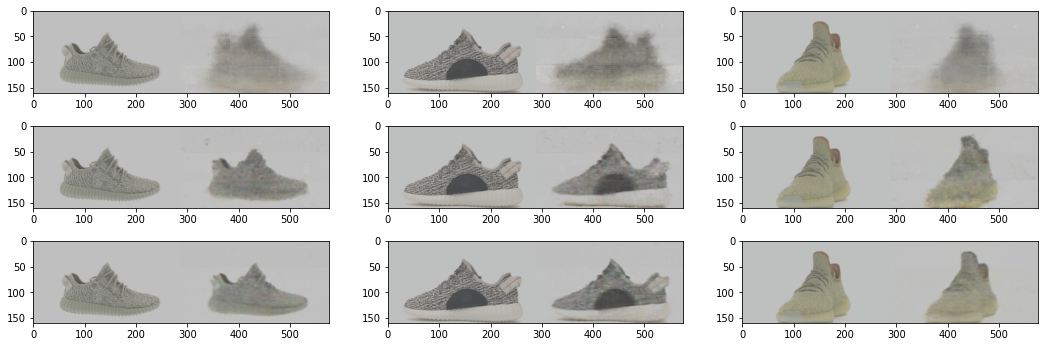

In [32]:
plt.figure(figsize = (18, 6))
plt.subplot(331)
plot_vae_result(X[0], simple_vae_2)
plt.subplot(332)
plot_vae_result(X[100], simple_vae_2)
plt.subplot(333)
plot_vae_result(X[1000], simple_vae_2)
plt.subplot(334)
plot_vae_result(X[0], simple_vae_32)
plt.subplot(335)
plot_vae_result(X[100], simple_vae_32)
plt.subplot(336)
plot_vae_result(X[1000], simple_vae_32)
plt.subplot(337)
plot_vae_result(X[0], simple_vae_128)
plt.subplot(338)
plot_vae_result(X[100], simple_vae_128)
plt.subplot(339)
plot_vae_result(X[1000], simple_vae_128)

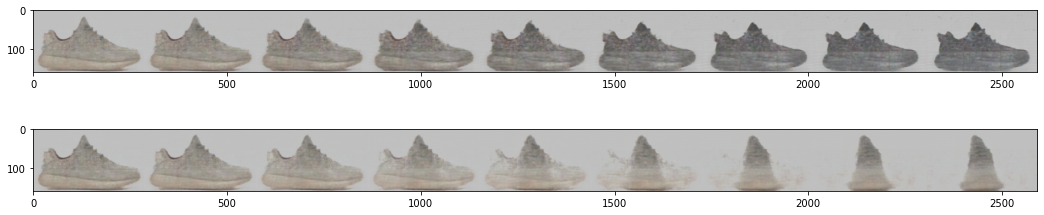

In [33]:
plt.figure(figsize=(18, 4))
plt.subplot(211)
img1_convert_to_img2(X[another_image_labels == 1][1], X[another_image_labels == 1][2], simple_vae_128)
plt.subplot(212)
img1_convert_to_img2(X[another_image_labels == 1][1], X[another_image_labels == 10][1], simple_vae_128)

In [34]:
res_simple_vae = simple_vae_128
res_latent_size = 128

In [35]:
with torch.no_grad():
  X_simple_encoded = res_simple_vae.encode(X.to(device)).to('cpu').detach().numpy()
if res_latent_size > 2:
  tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
  X_simple_tsne = tsne.fit_transform(X_simple_encoded)
else:
  X_simple_tsne = np.copy(X_simple_encoded) 

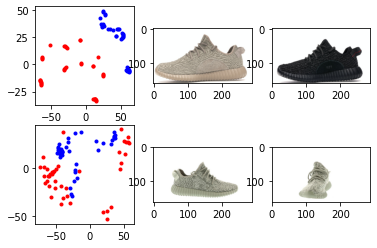

In [36]:
plt.subplot(231)
points1 = X_simple_tsne[y == 1]
points2 = X_simple_tsne[y == 2]
plt.plot(points1[:, 0], points1[:, 1], '.r')
plt.plot(points2[:, 0], points2[:, 1], '.b')
plt.subplot(232)
plt.imshow(images[y == 1][0])
plt.subplot(233)
plt.imshow(images[y == 2][0])

plt.subplot(234)
another_points1 = X_simple_tsne[another_image_labels == 1]
another_points2 = X_simple_tsne[another_image_labels == 8]
plt.plot(another_points1[:, 0], another_points1[:, 1], '.r')
plt.plot(another_points2[:, 0], another_points2[:, 1], '.b')
plt.subplot(235)
plt.imshow(images[another_image_labels == 1][0])
plt.subplot(236)
plt.imshow(images[another_image_labels == 8][0])

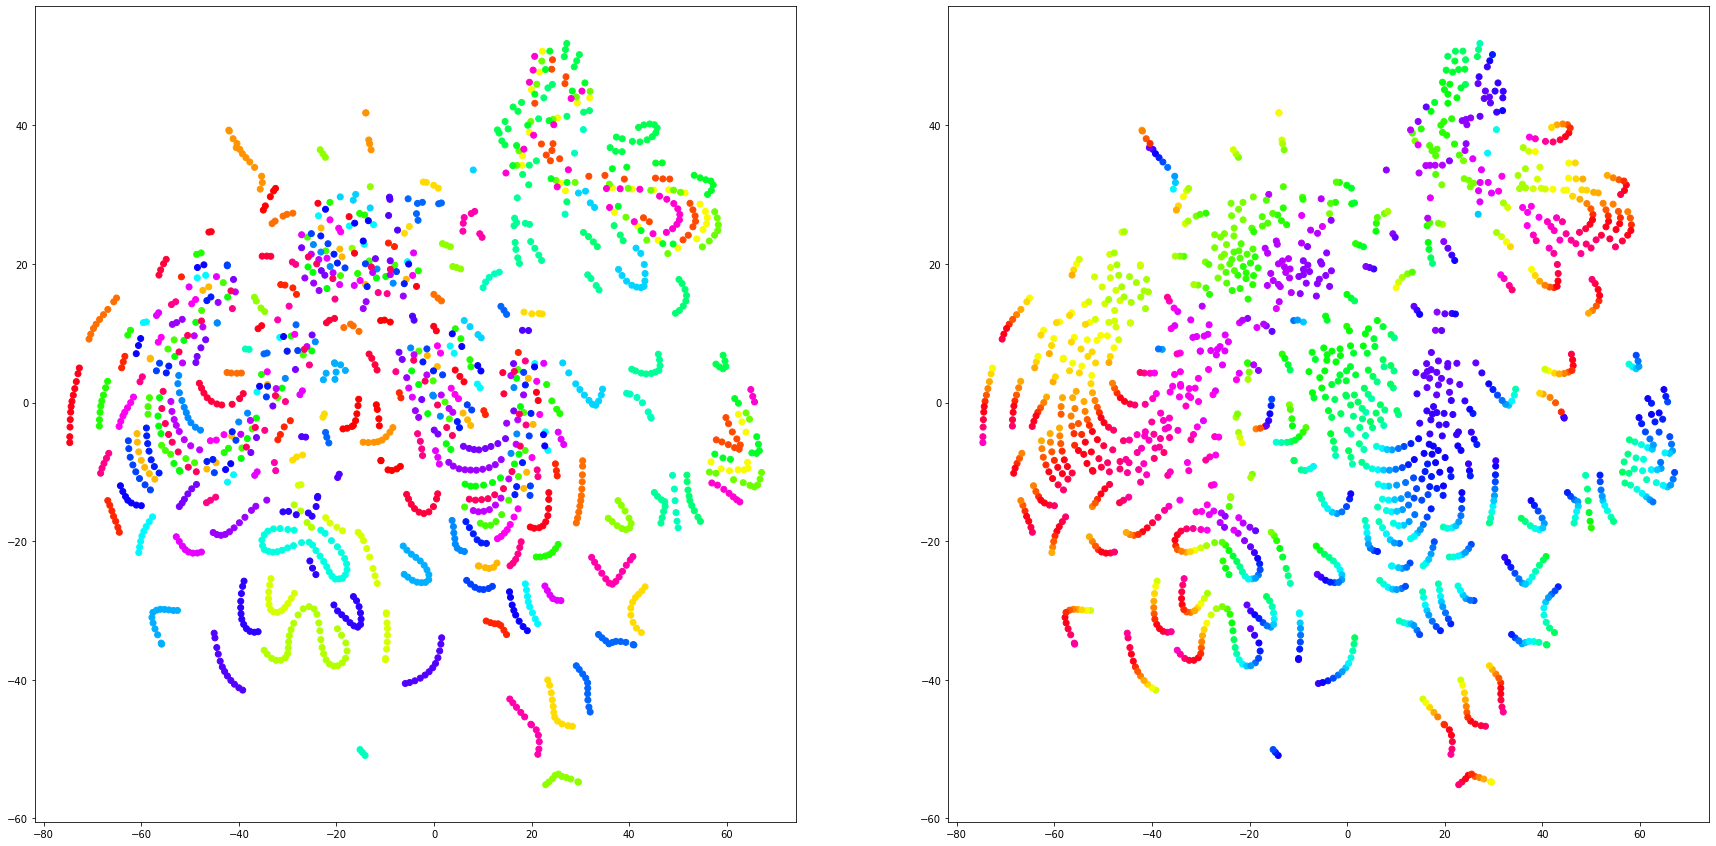

In [37]:
plt.figure(figsize = (30, 15))
plt.subplot(121)
# кластера классов
plt.scatter(X_simple_tsne[:, 0], X_simple_tsne[:, 1], c = plt.cm.get_cmap('hsv', len(np.unique(y)))(y))
plt.subplot(122)
# кластера ориентаций
plt.scatter(X_simple_tsne[:, 0], X_simple_tsne[:, 1], c = plt.cm.get_cmap('hsv', len(np.unique(another_image_labels)))(another_image_labels))

In [38]:
# В итоге хорошо различаем модели!
k = 5
print(f"Map {k} : {calc_map_k(X_simple_encoded, y, k)}")

Map 5 : 0.8745576548208127


In [39]:
# ориентацию не очень хорошо различаем (может быть потому что надо сделать их меньше)
k = 5
print(f"Map {k} : {calc_map_k(X_simple_encoded, another_image_labels, k)}")

Map 5 : 0.29620726495726496


In [40]:
t = np.unique(another_image_labels)
t = np.append(t[2:], t[:2])

new_another_image_labels = np.zeros_like(another_image_labels)
for i, l in enumerate(np.split(t, 9)):
  new_another_image_labels[(another_image_labels.reshape(-1, 1) == l).any(1)] = i

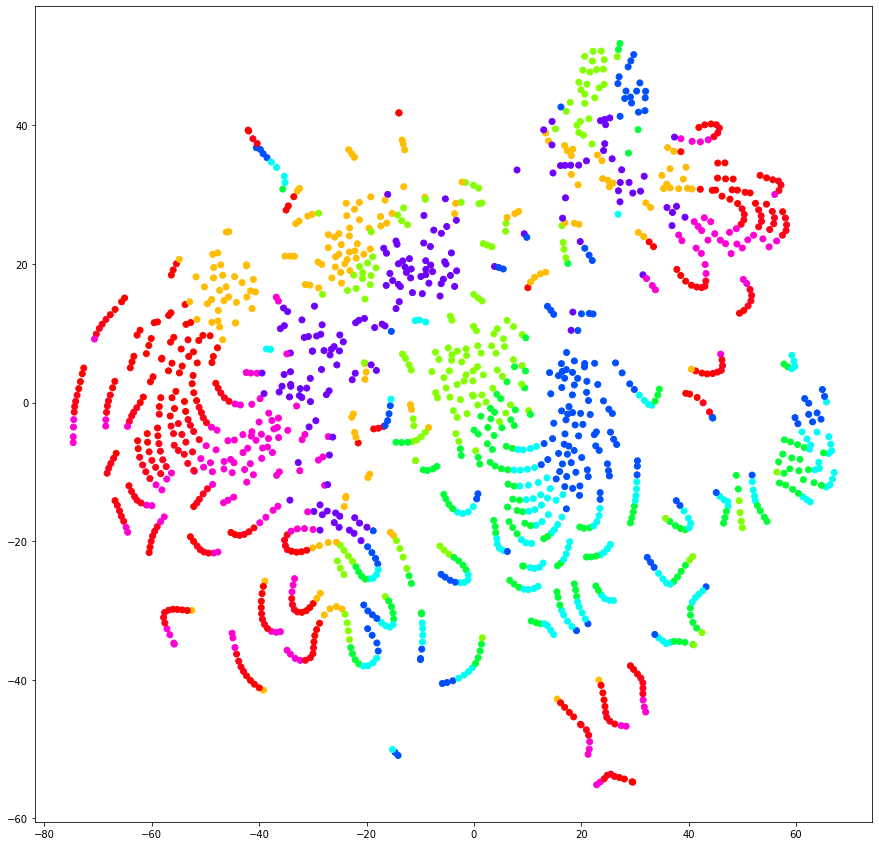

In [41]:
plt.figure(figsize = (15, 15))
plt.scatter(X_simple_tsne[:, 0], X_simple_tsne[:, 1], c = plt.cm.get_cmap('hsv', len(np.unique(new_another_image_labels)))(new_another_image_labels))

In [42]:
# другое дело
k = 5
print(f"Map {k} : {calc_map_k(X_simple_encoded, new_another_image_labels, k)}")

Map 5 : 0.8351804993252363


In [43]:
h, w = height // down_scale, width // down_scale
min_point = np.min(X_simple_tsne, axis = 0)
max_point = np.max(X_simple_tsne, axis = 0)

number_of_ceils = 25
x_range = np.linspace(min_point[0], max_point[0], number_of_ceils)
y_range = np.linspace(min_point[1], max_point[1], number_of_ceils)
image_map = np.zeros(((number_of_ceils - 1) * h, (number_of_ceils - 1) * w, 3), dtype = np.uint8)
for y in range(number_of_ceils-1):
  for x in range(number_of_ceils-1):
    left_down_corner = np.array([x_range[x], y_range[y]])
    right_up_corner = np.array([x_range[x+1], y_range[y+1]])
    
    mask = np.logical_and((X_simple_tsne >= left_down_corner).all(1), (X_simple_tsne < right_up_corner).all(1))
    if mask.sum() > 0:
      image_map[(number_of_ceils - 1) * h - (y+1)*h :(number_of_ceils - 1) * h - y * h,  x * w : (x + 1) * w] = images[mask][np.random.choice(np.arange(len(images[mask])))]

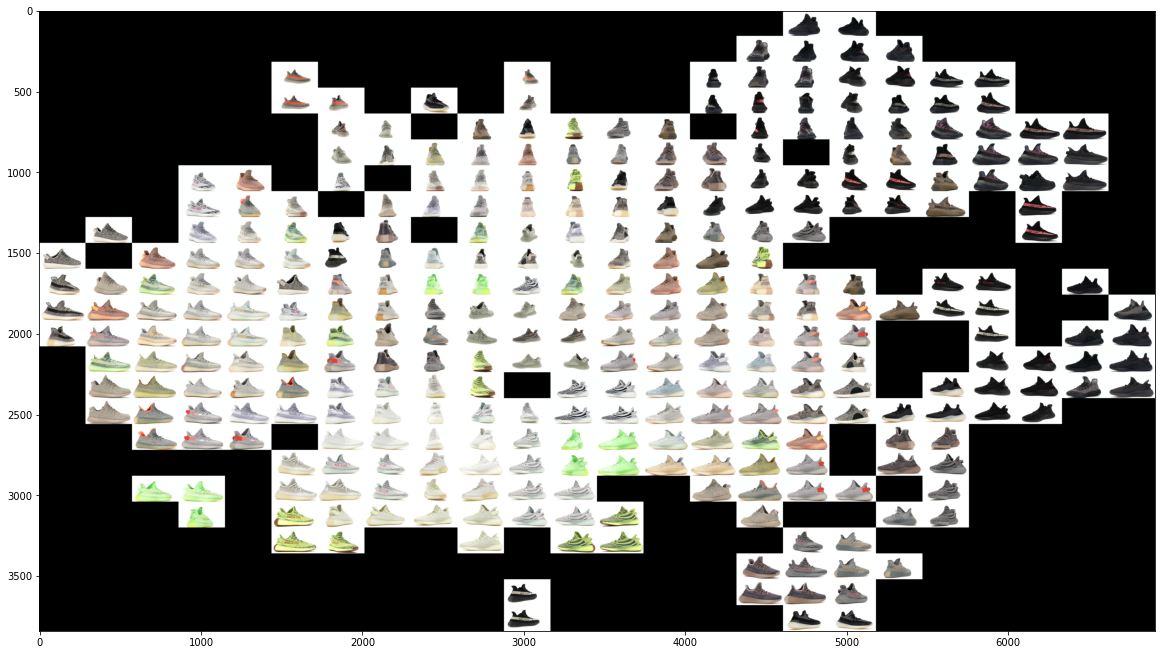

In [46]:
plt.figure(figsize=(20, 20))
plt.imshow(image_map)